<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [IMDB2] - Sentiment analysis with text embedding
<!-- DESC --> A very classical example of word embedding with a dataset from Internet Movie Database (IMDB)
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - The objective is to guess whether film reviews are **positive or negative** based on the analysis of the text. 
 - Understand the management of **textual data** and **sentiment analysis**

Original dataset can be find **[there](http://ai.stanford.edu/~amaas/data/sentiment/)**  
Note that [IMDb.com](https://imdb.com) offers several easy-to-use [datasets](https://www.imdb.com/interfaces/)  
For simplicity's sake, we'll use the dataset directly [embedded in Keras](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)

## What we're going to do :

 - Retrieve data
 - Preparing the data
 - Build a model
 - Train the model
 - Evaluate the result


## Step 1 - Import and init
### 1.1 - Python stuff

In [1]:
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.datasets.imdb as imdb

import matplotlib.pyplot as plt
import matplotlib

import os,sys,h5py,json
from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

run_dir = './run/IMDB2'
datasets_dir = pwk.init('IMDB2', run_dir)

<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.17
Notebook id          : IMDB2
Run time             : Monday 01 March 2021, 20:20:34
TensorFlow version   : 2.4.0
Keras version        : 2.4.0
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run/IMDB2
Update keras cache   : False
Save figs            : True
Path figs            : ./run/IMDB2/figs


### 1.2 - Parameters
The words in the vocabulary are classified from the most frequent to the rarest.  
`vocab_size` is the number of words we will remember in our vocabulary (the other words will be considered as unknown).  
`hide_most_frequently` is the number of ignored words, among the most common ones  
`review_len` is the review length  
`dense_vector_size` is the size of the generated dense vectors  
`output_dir` is where we will go to save our dictionaries. (./data is a good choice)

In [2]:
vocab_size           = 10000
hide_most_frequently = 0

review_len           = 256
dense_vector_size    = 16

epochs               = 30
batch_size           = 512

output_dir           = './data'

Override parameters (batch mode) - Just forget this cell

In [3]:
pwk.override('vocab_size', 'hide_most_frequently', 'review_len', 'dense_vector_size')
pwk.override('batch_size', 'epochs', 'output_dir')

## Step 2 - Retrieve data

IMDb dataset can bet get directly from Keras - see [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)  
Note : Due to their nature, textual data can be somewhat complex.

For more details about the management of this dataset, see notebook [IMDB1](01-One-hot-encoding.ipynb)

### 2.2 - Get dataset

In [4]:
(x_train, y_train), (x_test, y_test) = imdb.load_data( num_words=vocab_size, skip_top=hide_most_frequently, seed= 42,)

y_train = np.asarray(y_train).astype('float32')
y_test  = np.asarray(y_test ).astype('float32')

# ---- About
#
print("Max(x_train,x_test)  : ", pwk.rmax([x_train,x_test]) )
print("Min(x_train,x_test)  : ", pwk.rmin([x_train,x_test]) )
print("x_train : {}  y_train : {}".format(x_train.shape, y_train.shape))
print("x_test  : {}  y_test  : {}".format(x_test.shape,  y_test.shape))

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


/gpfslocalsup/pub/anaconda-py3/2020.02/envs/tensorflow-gpu-2.4.0/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


/gpfslocalsup/pub/anaconda-py3/2020.02/envs/tensorflow-gpu-2.4.0/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


Max(x_train,x_test)  :  9999


Min(x_train,x_test)  :  1
x_train : (25000,)  y_train : (25000,)
x_test  : (25000,)  y_test  : (25000,)


### 2.2 - Load dictionary
Not essential, but nice if you want to take a closer look at our reviews ;-)

In [5]:
# ---- Retrieve dictionary {word:index}, and encode it in ascii
#      Shift the dictionary from +3
#      Add <pad>, <start> and <unknown> tags
#      Create a reverse dictionary : {index:word}
#
word_index = imdb.get_word_index()
word_index = {w:(i+3) for w,i in word_index.items()}
word_index.update( {'<pad>':0, '<start>':1, '<unknown>':2, '<undef>':3,} )
index_word = {index:word for word,index in word_index.items()} 

# ---- A nice function to transpose :
#
def dataset2text(review):
    return ' '.join([index_word.get(i, '?') for i in review])

## Step 3 - Preprocess the data (padding)
In order to be processed by an NN, all entries must have the **same length.**  
We chose a review length of **review_len**  
We will therefore complete them with a padding (of \<pad\>\)  

In [6]:
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                     value   = 0,
                                                     padding = 'post',
                                                     maxlen  = review_len)

x_test  = keras.preprocessing.sequence.pad_sequences(x_test,
                                                     value   = 0 ,
                                                     padding = 'post',
                                                     maxlen  = review_len)

pwk.subtitle('After padding :')
print(x_train[12])

<br>**After padding :**

[   1   14   22 1367   53  206  159    4  636  898   74   26   11  436
  363  108    7   14  432   14   22    9 1055   34 8599    2    5  381
 3705 4509   14  768   47  839   25  111 1517 2579 1991  438 2663  587
    4  280  725    6   58   11 2714  201    4  206   16  702    5 5176
   19  480 5920  157   13   64  219    4    2   11  107  665 1212   39
    4  206    4   65  410   16  565    5   24   43  343   17 5602    8
  169  101   85  206  108    8 3008   14   25  215  168   18    6 2579
 1991  438    2   11  129 1609   36   26   66  290 3303   46    5  633
  115 4363    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

**Save dataset and dictionary (For future use but not mandatory)**

In [7]:
# ---- Write dataset in a h5 file, could be usefull
#
pwk.mkdir(output_dir)

with h5py.File(f'{output_dir}/dataset_imdb.h5', 'w') as f:
    f.create_dataset("x_train",    data=x_train)
    f.create_dataset("y_train",    data=y_train)
    f.create_dataset("x_test",     data=x_test)
    f.create_dataset("y_test",     data=y_test)

with open(f'{output_dir}/word_index.json', 'w') as fp:
    json.dump(word_index, fp)

with open(f'{output_dir}/index_word.json', 'w') as fp:
    json.dump(index_word, fp)

print('Saved.')

Saved.


## Step 4 - Build the model
Few remarks :
 - We'll choose a dense vector size for the embedding output with **dense_vector_size**
 - **GlobalAveragePooling1D** do a pooling on the last dimension : (None, lx, ly) -> (None, ly)  
   In other words: we average the set of vectors/words of a sentence
 - L'embedding de Keras fonctionne de manière supervisée. Il s'agit d'une couche de *vocab_size* neurones vers *n_neurons* permettant de maintenir une table de vecteurs (les poids constituent les vecteurs). Cette couche ne calcule pas de sortie a la façon des couches normales, mais renvois la valeur des vecteurs. n mots => n vecteurs (ensuite empilés par le pooling)  
Voir : [Explication plus détaillée (en)](https://stats.stackexchange.com/questions/324992/how-the-embedding-layer-is-trained-in-keras-embedding-layer)  
ainsi que : [Sentiment detection with Keras](https://www.liip.ch/en/blog/sentiment-detection-with-keras-word-embeddings-and-lstm-deep-learning-networks)  

More documentation about this model functions :
 - [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)
 - [GlobalAveragePooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D)

In [8]:
def get_model(vocab_size=10000, dense_vector_size=32, review_len=256):
    
    model = keras.Sequential()
    model.add(keras.layers.Input( shape=(review_len,) ))
    model.add(keras.layers.Embedding(input_dim    = vocab_size, 
                                     output_dim   = dense_vector_size, 
                                     input_length = review_len))
    model.add(keras.layers.GlobalAveragePooling1D())
    model.add(keras.layers.Dense(dense_vector_size, activation='relu'))
    model.add(keras.layers.Dense(1,                 activation='sigmoid'))

    model.compile(optimizer = 'adam',
                  loss      = 'binary_crossentropy',
                  metrics   = ['accuracy'])
    return model

## Step 5 - Train the model
### 5.1 - Get it

In [9]:
model = get_model(vocab_size, dense_vector_size, review_len)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


### 5.2 - Add callback

In [10]:
os.makedirs(f'{run_dir}/models',   mode=0o750, exist_ok=True)
save_dir = f'{run_dir}/models/best_model.h5'
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 5.1 - Train it

In [11]:
%%time

history = model.fit(x_train,
                    y_train,
                    epochs          = epochs,
                    batch_size      = batch_size,
                    validation_data = (x_test, y_test),
                    verbose         = 1,
                    callbacks       = [savemodel_callback])


Epoch 1/30


 1/49 [..............................] - ETA: 1:04 - loss: 0.6932 - accuracy: 0.4727

 8/49 [===>..........................] - ETA: 0s - loss: 0.6931 - accuracy: 0.4978  

16/49 [========>.....................] - ETA: 0s - loss: 0.6930 - accuracy: 0.5180

24/49 [=============>................] - ETA: 0s - loss: 0.6929 - accuracy: 0.5276

32/49 [==================>...........] - ETA: 0s - loss: 0.6927 - accuracy: 0.5389

40/49 [=======================>......] - ETA: 0s - loss: 0.6926 - accuracy: 0.5516

48/49 [============================>.] - ETA: 0s - loss: 0.6924 - accuracy: 0.5639

49/49 [==============================] - 3s 27ms/step - loss: 0.6923 - accuracy: 0.5667 - val_loss: 0.6879 - val_accuracy: 0.7070


Epoch 2/30
 1/49 [..............................] - ETA: 0s - loss: 0.6872 - accuracy: 0.7324

 9/49 [====>.........................] - ETA: 0s - loss: 0.6868 - accuracy: 0.7287

17/49 [=========>....................] - ETA: 0s - loss: 0.6863 - accuracy: 0.7254

25/49 [==============>...............] - ETA: 0s - loss: 0.6858 - accuracy: 0.7214

33/49 [===================>..........] - ETA: 0s - loss: 0.6852 - accuracy: 0.7168

41/49 [========================>.....] - ETA: 0s - loss: 0.6844 - accuracy: 0.7123

49/49 [==============================] - ETA: 0s - loss: 0.6836 - accuracy: 0.7101

49/49 [==============================] - 1s 11ms/step - loss: 0.6835 - accuracy: 0.7100 - val_loss: 0.6664 - val_accuracy: 0.7461


Epoch 3/30
 1/49 [..............................] - ETA: 0s - loss: 0.6633 - accuracy: 0.7734

 9/49 [====>.........................] - ETA: 0s - loss: 0.6633 - accuracy: 0.7599

17/49 [=========>....................] - ETA: 0s - loss: 0.6620 - accuracy: 0.7561

25/49 [==============>...............] - ETA: 0s - loss: 0.6603 - accuracy: 0.7562

33/49 [===================>..........] - ETA: 0s - loss: 0.6584 - accuracy: 0.7583

41/49 [========================>.....] - ETA: 0s - loss: 0.6566 - accuracy: 0.7601

49/49 [==============================] - ETA: 0s - loss: 0.6547 - accuracy: 0.7618

49/49 [==============================] - 1s 11ms/step - loss: 0.6545 - accuracy: 0.7620 - val_loss: 0.6210 - val_accuracy: 0.7759


Epoch 4/30
 1/49 [..............................] - ETA: 0s - loss: 0.6161 - accuracy: 0.7910

 9/49 [====>.........................] - ETA: 0s - loss: 0.6127 - accuracy: 0.7956

17/49 [=========>....................] - ETA: 0s - loss: 0.6105 - accuracy: 0.7944

25/49 [==============>...............] - ETA: 0s - loss: 0.6081 - accuracy: 0.7949

33/49 [===================>..........] - ETA: 0s - loss: 0.6054 - accuracy: 0.7962

41/49 [========================>.....] - ETA: 0s - loss: 0.6026 - accuracy: 0.7978

49/49 [==============================] - ETA: 0s - loss: 0.5997 - accuracy: 0.7994

49/49 [==============================] - 1s 11ms/step - loss: 0.5994 - accuracy: 0.7996 - val_loss: 0.5568 - val_accuracy: 0.8036


Epoch 5/30
 1/49 [..............................] - ETA: 0s - loss: 0.5372 - accuracy: 0.8438

 9/49 [====>.........................] - ETA: 0s - loss: 0.5421 - accuracy: 0.8358

17/49 [=========>....................] - ETA: 0s - loss: 0.5396 - accuracy: 0.8330

25/49 [==============>...............] - ETA: 0s - loss: 0.5369 - accuracy: 0.8309

33/49 [===================>..........] - ETA: 0s - loss: 0.5341 - accuracy: 0.8301

41/49 [========================>.....] - ETA: 0s - loss: 0.5312 - accuracy: 0.8301

49/49 [==============================] - ETA: 0s - loss: 0.5282 - accuracy: 0.8306

49/49 [==============================] - 1s 11ms/step - loss: 0.5278 - accuracy: 0.8307 - val_loss: 0.4907 - val_accuracy: 0.8282


Epoch 6/30
 1/49 [..............................] - ETA: 0s - loss: 0.4703 - accuracy: 0.8633

 9/49 [====>.........................] - ETA: 0s - loss: 0.4642 - accuracy: 0.8633

17/49 [=========>....................] - ETA: 0s - loss: 0.4633 - accuracy: 0.8594

25/49 [==============>...............] - ETA: 0s - loss: 0.4615 - accuracy: 0.8573

33/49 [===================>..........] - ETA: 0s - loss: 0.4595 - accuracy: 0.8563

41/49 [========================>.....] - ETA: 0s - loss: 0.4573 - accuracy: 0.8560

49/49 [==============================] - ETA: 0s - loss: 0.4551 - accuracy: 0.8561

49/49 [==============================] - 1s 11ms/step - loss: 0.4548 - accuracy: 0.8561 - val_loss: 0.4349 - val_accuracy: 0.8453


Epoch 7/30
 1/49 [..............................] - ETA: 0s - loss: 0.4195 - accuracy: 0.8633

 9/49 [====>.........................] - ETA: 0s - loss: 0.4100 - accuracy: 0.8701

17/49 [=========>....................] - ETA: 0s - loss: 0.4071 - accuracy: 0.8705

25/49 [==============>...............] - ETA: 0s - loss: 0.4046 - accuracy: 0.8712

33/49 [===================>..........] - ETA: 0s - loss: 0.4025 - accuracy: 0.8713

41/49 [========================>.....] - ETA: 0s - loss: 0.4003 - accuracy: 0.8714

49/49 [==============================] - ETA: 0s - loss: 0.3984 - accuracy: 0.8715

49/49 [==============================] - 1s 11ms/step - loss: 0.3982 - accuracy: 0.8715 - val_loss: 0.3943 - val_accuracy: 0.8547


Epoch 8/30
 1/49 [..............................] - ETA: 0s - loss: 0.3716 - accuracy: 0.8848

 9/49 [====>.........................] - ETA: 0s - loss: 0.3637 - accuracy: 0.8840

17/49 [=========>....................] - ETA: 0s - loss: 0.3618 - accuracy: 0.8844

25/49 [==============>...............] - ETA: 0s - loss: 0.3589 - accuracy: 0.8849

33/49 [===================>..........] - ETA: 0s - loss: 0.3572 - accuracy: 0.8847

41/49 [========================>.....] - ETA: 0s - loss: 0.3557 - accuracy: 0.8845

49/49 [==============================] - ETA: 0s - loss: 0.3542 - accuracy: 0.8844

49/49 [==============================] - 1s 11ms/step - loss: 0.3540 - accuracy: 0.8844 - val_loss: 0.3646 - val_accuracy: 0.8607


Epoch 9/30
 1/49 [..............................] - ETA: 0s - loss: 0.3275 - accuracy: 0.8770

 9/49 [====>.........................] - ETA: 0s - loss: 0.3255 - accuracy: 0.8850

17/49 [=========>....................] - ETA: 0s - loss: 0.3227 - accuracy: 0.8889

25/49 [==============>...............] - ETA: 0s - loss: 0.3210 - accuracy: 0.8903

33/49 [===================>..........] - ETA: 0s - loss: 0.3200 - accuracy: 0.8907

41/49 [========================>.....] - ETA: 0s - loss: 0.3193 - accuracy: 0.8908

49/49 [==============================] - ETA: 0s - loss: 0.3186 - accuracy: 0.8909

49/49 [==============================] - 1s 11ms/step - loss: 0.3185 - accuracy: 0.8909 - val_loss: 0.3443 - val_accuracy: 0.8652


Epoch 10/30
 1/49 [..............................] - ETA: 0s - loss: 0.2851 - accuracy: 0.9062

 9/49 [====>.........................] - ETA: 0s - loss: 0.2991 - accuracy: 0.8940

17/49 [=========>....................] - ETA: 0s - loss: 0.2996 - accuracy: 0.8938

25/49 [==============>...............] - ETA: 0s - loss: 0.2985 - accuracy: 0.8943

33/49 [===================>..........] - ETA: 0s - loss: 0.2972 - accuracy: 0.8946

41/49 [========================>.....] - ETA: 0s - loss: 0.2963 - accuracy: 0.8948

49/49 [==============================] - ETA: 0s - loss: 0.2954 - accuracy: 0.8952

49/49 [==============================] - 1s 11ms/step - loss: 0.2953 - accuracy: 0.8952 - val_loss: 0.3282 - val_accuracy: 0.8693


Epoch 11/30
 1/49 [..............................] - ETA: 0s - loss: 0.3048 - accuracy: 0.8789

 9/49 [====>.........................] - ETA: 0s - loss: 0.2819 - accuracy: 0.8934

17/49 [=========>....................] - ETA: 0s - loss: 0.2795 - accuracy: 0.8964

25/49 [==============>...............] - ETA: 0s - loss: 0.2774 - accuracy: 0.8987

33/49 [===================>..........] - ETA: 0s - loss: 0.2759 - accuracy: 0.8997

41/49 [========================>.....] - ETA: 0s - loss: 0.2753 - accuracy: 0.9002

49/49 [==============================] - ETA: 0s - loss: 0.2746 - accuracy: 0.9007

49/49 [==============================] - 1s 11ms/step - loss: 0.2746 - accuracy: 0.9007 - val_loss: 0.3167 - val_accuracy: 0.8720


Epoch 12/30
 1/49 [..............................] - ETA: 0s - loss: 0.2703 - accuracy: 0.8984

 9/49 [====>.........................] - ETA: 0s - loss: 0.2630 - accuracy: 0.9061

17/49 [=========>....................] - ETA: 0s - loss: 0.2592 - accuracy: 0.9075

25/49 [==============>...............] - ETA: 0s - loss: 0.2568 - accuracy: 0.9082

33/49 [===================>..........] - ETA: 0s - loss: 0.2555 - accuracy: 0.9088

41/49 [========================>.....] - ETA: 0s - loss: 0.2550 - accuracy: 0.9089

49/49 [==============================] - ETA: 0s - loss: 0.2547 - accuracy: 0.9090

49/49 [==============================] - 1s 11ms/step - loss: 0.2547 - accuracy: 0.9090 - val_loss: 0.3086 - val_accuracy: 0.8742


Epoch 13/30
 1/49 [..............................] - ETA: 0s - loss: 0.2151 - accuracy: 0.9375

 9/49 [====>.........................] - ETA: 0s - loss: 0.2402 - accuracy: 0.9192

17/49 [=========>....................] - ETA: 0s - loss: 0.2414 - accuracy: 0.9174

25/49 [==============>...............] - ETA: 0s - loss: 0.2418 - accuracy: 0.9168

33/49 [===================>..........] - ETA: 0s - loss: 0.2422 - accuracy: 0.9163

41/49 [========================>.....] - ETA: 0s - loss: 0.2423 - accuracy: 0.9160

49/49 [==============================] - ETA: 0s - loss: 0.2420 - accuracy: 0.9159

49/49 [==============================] - 1s 11ms/step - loss: 0.2419 - accuracy: 0.9159 - val_loss: 0.3013 - val_accuracy: 0.8768


Epoch 14/30
 1/49 [..............................] - ETA: 0s - loss: 0.2512 - accuracy: 0.9258

 9/49 [====>.........................] - ETA: 0s - loss: 0.2327 - accuracy: 0.9218

17/49 [=========>....................] - ETA: 0s - loss: 0.2303 - accuracy: 0.9212

25/49 [==============>...............] - ETA: 0s - loss: 0.2293 - accuracy: 0.9212

33/49 [===================>..........] - ETA: 0s - loss: 0.2287 - accuracy: 0.9212

41/49 [========================>.....] - ETA: 0s - loss: 0.2285 - accuracy: 0.9208

49/49 [==============================] - ETA: 0s - loss: 0.2283 - accuracy: 0.9205

49/49 [==============================] - 1s 11ms/step - loss: 0.2283 - accuracy: 0.9205 - val_loss: 0.2961 - val_accuracy: 0.8786


Epoch 15/30
 1/49 [..............................] - ETA: 0s - loss: 0.2329 - accuracy: 0.9160

 9/49 [====>.........................] - ETA: 0s - loss: 0.2140 - accuracy: 0.9251

17/49 [=========>....................] - ETA: 0s - loss: 0.2141 - accuracy: 0.9254

25/49 [==============>...............] - ETA: 0s - loss: 0.2137 - accuracy: 0.9253

33/49 [===================>..........] - ETA: 0s - loss: 0.2138 - accuracy: 0.9250

41/49 [========================>.....] - ETA: 0s - loss: 0.2143 - accuracy: 0.9246

49/49 [==============================] - ETA: 0s - loss: 0.2148 - accuracy: 0.9242

49/49 [==============================] - 1s 11ms/step - loss: 0.2148 - accuracy: 0.9242 - val_loss: 0.2943 - val_accuracy: 0.8782


Epoch 16/30
 1/49 [..............................] - ETA: 0s - loss: 0.2576 - accuracy: 0.9023

 9/49 [====>.........................] - ETA: 0s - loss: 0.2193 - accuracy: 0.9221

17/49 [=========>....................] - ETA: 0s - loss: 0.2114 - accuracy: 0.9254

25/49 [==============>...............] - ETA: 0s - loss: 0.2093 - accuracy: 0.9261

33/49 [===================>..........] - ETA: 0s - loss: 0.2083 - accuracy: 0.9265

41/49 [========================>.....] - ETA: 0s - loss: 0.2078 - accuracy: 0.9267

49/49 [==============================] - ETA: 0s - loss: 0.2075 - accuracy: 0.9268

49/49 [==============================] - 1s 11ms/step - loss: 0.2075 - accuracy: 0.9268 - val_loss: 0.2900 - val_accuracy: 0.8816


Epoch 17/30
 1/49 [..............................] - ETA: 0s - loss: 0.2032 - accuracy: 0.9316

 9/49 [====>.........................] - ETA: 0s - loss: 0.2034 - accuracy: 0.9289

17/49 [=========>....................] - ETA: 0s - loss: 0.2017 - accuracy: 0.9291

25/49 [==============>...............] - ETA: 0s - loss: 0.2011 - accuracy: 0.9290

33/49 [===================>..........] - ETA: 0s - loss: 0.2009 - accuracy: 0.9291

41/49 [========================>.....] - ETA: 0s - loss: 0.2008 - accuracy: 0.9290

49/49 [==============================] - ETA: 0s - loss: 0.2004 - accuracy: 0.9292

49/49 [==============================] - 1s 11ms/step - loss: 0.2003 - accuracy: 0.9292 - val_loss: 0.2884 - val_accuracy: 0.8826


Epoch 18/30
 1/49 [..............................] - ETA: 0s - loss: 0.1817 - accuracy: 0.9375

 9/49 [====>.........................] - ETA: 0s - loss: 0.1808 - accuracy: 0.9353

17/49 [=========>....................] - ETA: 0s - loss: 0.1817 - accuracy: 0.9357

25/49 [==============>...............] - ETA: 0s - loss: 0.1821 - accuracy: 0.9360

33/49 [===================>..........] - ETA: 0s - loss: 0.1826 - accuracy: 0.9360

41/49 [========================>.....] - ETA: 0s - loss: 0.1832 - accuracy: 0.9358

49/49 [==============================] - ETA: 0s - loss: 0.1840 - accuracy: 0.9356

49/49 [==============================] - 1s 11ms/step - loss: 0.1841 - accuracy: 0.9355 - val_loss: 0.2871 - val_accuracy: 0.8828


Epoch 19/30
 1/49 [..............................] - ETA: 0s - loss: 0.1765 - accuracy: 0.9473

 9/49 [====>.........................] - ETA: 0s - loss: 0.1914 - accuracy: 0.9356

17/49 [=========>....................] - ETA: 0s - loss: 0.1896 - accuracy: 0.9349

25/49 [==============>...............] - ETA: 0s - loss: 0.1882 - accuracy: 0.9350

33/49 [===================>..........] - ETA: 0s - loss: 0.1870 - accuracy: 0.9353

41/49 [========================>.....] - ETA: 0s - loss: 0.1863 - accuracy: 0.9355

49/49 [==============================] - ETA: 0s - loss: 0.1857 - accuracy: 0.9356

49/49 [==============================] - 1s 11ms/step - loss: 0.1856 - accuracy: 0.9356 - val_loss: 0.2869 - val_accuracy: 0.8835


Epoch 20/30
 1/49 [..............................] - ETA: 0s - loss: 0.1732 - accuracy: 0.9453

 9/49 [====>.........................] - ETA: 0s - loss: 0.1767 - accuracy: 0.9414

17/49 [=========>....................] - ETA: 0s - loss: 0.1771 - accuracy: 0.9398

25/49 [==============>...............] - ETA: 0s - loss: 0.1769 - accuracy: 0.9396

33/49 [===================>..........] - ETA: 0s - loss: 0.1766 - accuracy: 0.9394

41/49 [========================>.....] - ETA: 0s - loss: 0.1764 - accuracy: 0.9394

49/49 [==============================] - ETA: 0s - loss: 0.1764 - accuracy: 0.9394

49/49 [==============================] - 1s 11ms/step - loss: 0.1763 - accuracy: 0.9394 - val_loss: 0.2878 - val_accuracy: 0.8824


Epoch 21/30
 1/49 [..............................] - ETA: 0s - loss: 0.1767 - accuracy: 0.9375

 8/49 [===>..........................] - ETA: 0s - loss: 0.1742 - accuracy: 0.9379

16/49 [========>.....................] - ETA: 0s - loss: 0.1711 - accuracy: 0.9391

24/49 [=============>................] - ETA: 0s - loss: 0.1695 - accuracy: 0.9401

32/49 [==================>...........] - ETA: 0s - loss: 0.1690 - accuracy: 0.9407

40/49 [=======================>......] - ETA: 0s - loss: 0.1692 - accuracy: 0.9407

48/49 [============================>.] - ETA: 0s - loss: 0.1691 - accuracy: 0.9409

49/49 [==============================] - 1s 11ms/step - loss: 0.1691 - accuracy: 0.9410 - val_loss: 0.2882 - val_accuracy: 0.8834


Epoch 22/30
 1/49 [..............................] - ETA: 0s - loss: 0.1473 - accuracy: 0.9551

 9/49 [====>.........................] - ETA: 0s - loss: 0.1614 - accuracy: 0.9461

17/49 [=========>....................] - ETA: 0s - loss: 0.1635 - accuracy: 0.9448

25/49 [==============>...............] - ETA: 0s - loss: 0.1635 - accuracy: 0.9446

33/49 [===================>..........] - ETA: 0s - loss: 0.1634 - accuracy: 0.9446

41/49 [========================>.....] - ETA: 0s - loss: 0.1631 - accuracy: 0.9447

49/49 [==============================] - ETA: 0s - loss: 0.1628 - accuracy: 0.9448

49/49 [==============================] - 1s 11ms/step - loss: 0.1628 - accuracy: 0.9448 - val_loss: 0.2901 - val_accuracy: 0.8828


Epoch 23/30


 1/49 [..............................] - ETA: 0s - loss: 0.1583 - accuracy: 0.9492

 9/49 [====>.........................] - ETA: 0s - loss: 0.1560 - accuracy: 0.9483

17/49 [=========>....................] - ETA: 0s - loss: 0.1573 - accuracy: 0.9482

25/49 [==============>...............] - ETA: 0s - loss: 0.1579 - accuracy: 0.9477

33/49 [===================>..........] - ETA: 0s - loss: 0.1579 - accuracy: 0.9476

41/49 [========================>.....] - ETA: 0s - loss: 0.1578 - accuracy: 0.9475

49/49 [==============================] - ETA: 0s - loss: 0.1576 - accuracy: 0.9475

49/49 [==============================] - 1s 11ms/step - loss: 0.1576 - accuracy: 0.9475 - val_loss: 0.2911 - val_accuracy: 0.8823


Epoch 24/30
 1/49 [..............................] - ETA: 0s - loss: 0.1543 - accuracy: 0.9434

 9/49 [====>.........................] - ETA: 0s - loss: 0.1553 - accuracy: 0.9478

17/49 [=========>....................] - ETA: 0s - loss: 0.1540 - accuracy: 0.9485

25/49 [==============>...............] - ETA: 0s - loss: 0.1528 - accuracy: 0.9490

33/49 [===================>..........] - ETA: 0s - loss: 0.1521 - accuracy: 0.9493

41/49 [========================>.....] - ETA: 0s - loss: 0.1516 - accuracy: 0.9494

49/49 [==============================] - ETA: 0s - loss: 0.1513 - accuracy: 0.9494

49/49 [==============================] - 1s 11ms/step - loss: 0.1513 - accuracy: 0.9494 - val_loss: 0.2944 - val_accuracy: 0.8818


Epoch 25/30


 1/49 [..............................] - ETA: 0s - loss: 0.1706 - accuracy: 0.9414

 9/49 [====>.........................] - ETA: 0s - loss: 0.1627 - accuracy: 0.9449

17/49 [=========>....................] - ETA: 0s - loss: 0.1541 - accuracy: 0.9484

25/49 [==============>...............] - ETA: 0s - loss: 0.1503 - accuracy: 0.9505

33/49 [===================>..........] - ETA: 0s - loss: 0.1488 - accuracy: 0.9512

41/49 [========================>.....] - ETA: 0s - loss: 0.1478 - accuracy: 0.9514

49/49 [==============================] - ETA: 0s - loss: 0.1474 - accuracy: 0.9515

49/49 [==============================] - 1s 11ms/step - loss: 0.1474 - accuracy: 0.9515 - val_loss: 0.2958 - val_accuracy: 0.8824


Epoch 26/30
 1/49 [..............................] - ETA: 0s - loss: 0.1482 - accuracy: 0.9668

 9/49 [====>.........................] - ETA: 0s - loss: 0.1465 - accuracy: 0.9538

17/49 [=========>....................] - ETA: 0s - loss: 0.1454 - accuracy: 0.9522

25/49 [==============>...............] - ETA: 0s - loss: 0.1440 - accuracy: 0.9520

33/49 [===================>..........] - ETA: 0s - loss: 0.1435 - accuracy: 0.9520

41/49 [========================>.....] - ETA: 0s - loss: 0.1431 - accuracy: 0.9520

49/49 [==============================] - ETA: 0s - loss: 0.1428 - accuracy: 0.9520

49/49 [==============================] - 1s 11ms/step - loss: 0.1428 - accuracy: 0.9521 - val_loss: 0.3007 - val_accuracy: 0.8799


Epoch 27/30
 1/49 [..............................] - ETA: 0s - loss: 0.1331 - accuracy: 0.9570

 9/49 [====>.........................] - ETA: 0s - loss: 0.1381 - accuracy: 0.9567

17/49 [=========>....................] - ETA: 0s - loss: 0.1375 - accuracy: 0.9570

25/49 [==============>...............] - ETA: 0s - loss: 0.1371 - accuracy: 0.9568

33/49 [===================>..........] - ETA: 0s - loss: 0.1368 - accuracy: 0.9565

41/49 [========================>.....] - ETA: 0s - loss: 0.1368 - accuracy: 0.9562

49/49 [==============================] - ETA: 0s - loss: 0.1369 - accuracy: 0.9559

49/49 [==============================] - 1s 11ms/step - loss: 0.1369 - accuracy: 0.9559 - val_loss: 0.3032 - val_accuracy: 0.8800


Epoch 28/30
 1/49 [..............................] - ETA: 0s - loss: 0.1147 - accuracy: 0.9609

 9/49 [====>.........................] - ETA: 0s - loss: 0.1233 - accuracy: 0.9589

17/49 [=========>....................] - ETA: 0s - loss: 0.1253 - accuracy: 0.9585

25/49 [==============>...............] - ETA: 0s - loss: 0.1265 - accuracy: 0.9582

33/49 [===================>..........] - ETA: 0s - loss: 0.1275 - accuracy: 0.9578

41/49 [========================>.....] - ETA: 0s - loss: 0.1284 - accuracy: 0.9576

49/49 [==============================] - ETA: 0s - loss: 0.1290 - accuracy: 0.9575

49/49 [==============================] - 1s 11ms/step - loss: 0.1291 - accuracy: 0.9574 - val_loss: 0.3085 - val_accuracy: 0.8780


Epoch 29/30


 1/49 [..............................] - ETA: 0s - loss: 0.1255 - accuracy: 0.9590

 9/49 [====>.........................] - ETA: 0s - loss: 0.1278 - accuracy: 0.9586

17/49 [=========>....................] - ETA: 0s - loss: 0.1275 - accuracy: 0.9588

25/49 [==============>...............] - ETA: 0s - loss: 0.1275 - accuracy: 0.9590

33/49 [===================>..........] - ETA: 0s - loss: 0.1271 - accuracy: 0.9593

41/49 [========================>.....] - ETA: 0s - loss: 0.1270 - accuracy: 0.9594

49/49 [==============================] - ETA: 0s - loss: 0.1270 - accuracy: 0.9593

49/49 [==============================] - 1s 11ms/step - loss: 0.1271 - accuracy: 0.9593 - val_loss: 0.3094 - val_accuracy: 0.8804


Epoch 30/30
 1/49 [..............................] - ETA: 0s - loss: 0.1288 - accuracy: 0.9570

 9/49 [====>.........................] - ETA: 0s - loss: 0.1156 - accuracy: 0.9629

17/49 [=========>....................] - ETA: 0s - loss: 0.1175 - accuracy: 0.9627

25/49 [==============>...............] - ETA: 0s - loss: 0.1187 - accuracy: 0.9626

33/49 [===================>..........] - ETA: 0s - loss: 0.1196 - accuracy: 0.9623

41/49 [========================>.....] - ETA: 0s - loss: 0.1205 - accuracy: 0.9619

49/49 [==============================] - ETA: 0s - loss: 0.1210 - accuracy: 0.9616

49/49 [==============================] - 1s 11ms/step - loss: 0.1211 - accuracy: 0.9616 - val_loss: 0.3134 - val_accuracy: 0.8781


CPU times: user 31.9 s, sys: 2.62 s, total: 34.5 s
Wall time: 19.2 s


## Step 6 - Evaluate
### 6.1 - Training history

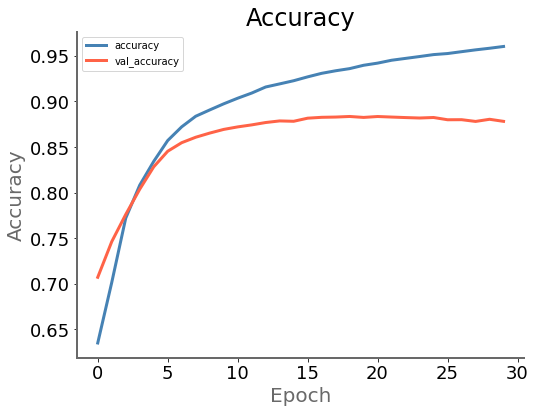

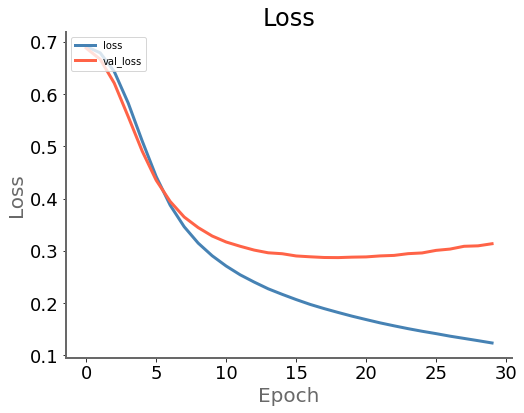

In [12]:
pwk.plot_history(history, save_as='02-history')

### 6.2 - Reload and evaluate best model

x_test / loss      : 0.2869
x_test / accuracy  : 0.8835


#### Accuracy donut is :

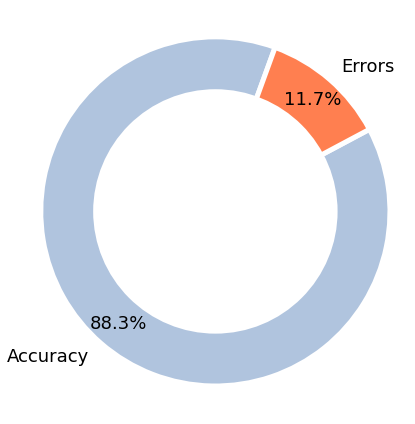

#### Confusion matrix is :

,0,1
0,0.89,0.11
1,0.12,0.88


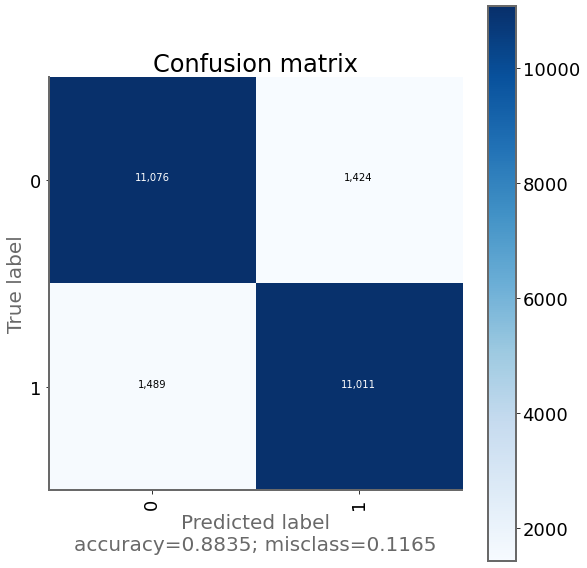

In [13]:
model = keras.models.load_model(f'{run_dir}/models/best_model.h5')

# ---- Evaluate
score  = model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / accuracy  : {:5.4f}'.format(score[1]))

values=[score[1], 1-score[1]]
pwk.plot_donut(values,["Accuracy","Errors"], title="#### Accuracy donut is :", save_as='03-donut')

# ---- Confusion matrix

y_sigmoid = model.predict(x_test)

y_pred = y_sigmoid.copy()
y_pred[ y_sigmoid< 0.5 ] = 0
y_pred[ y_sigmoid>=0.5 ] = 1    

pwk.display_confusion_matrix(y_test,y_pred,labels=range(2))
pwk.plot_confusion_matrix(y_test,y_pred,range(2), figsize=(8, 8),normalize=False, save_as='04-confusion-matrix')

In [14]:
pwk.end()

End time is : Monday 01 March 2021, 20:21:18
Duration is : 00:00:43 104ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>